# Toronto anomalies analysis
Anomalies detection and performance measurement

### Importing necessary libraries

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import utils
import os.path
from __future__ import division
from sklearn import preprocessing
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

### Loading the data

In [2]:
SITE = 7879
channels = pd.read_csv('../dataset/channels.csv')
channels[channels.siteId == SITE].head()

,siteId,channelId,channelName,units,isCalculated
81434,7879,11723,MP1 BTYVOLT,V,False
81435,7879,11722,MP1 UpDEPTH_1,mm,False
81436,7879,11721,MP1 UNIDEPTH,mm,False
81437,7879,11720,MP1 RAWVEL,m/s,False
81438,7879,11719,MP1 PEAKVEL_1,m/s,False


### Assigning the channelId value to variable

In [4]:
up_depth = 11722
p_depth = 11718
d_final = 11724

### Using utils to load the values from chosen channels

In [5]:
up_depth = utils.load_channel_data(SITE, up_depth).rename('up_depth').fillna(0)
p_depth = utils.load_channel_data(SITE, p_depth).rename('p_depth').fillna(0)
d_final = utils.load_channel_data(SITE, d_final).rename('d_final').fillna(0)

### Short description of the data

In [6]:
up_depth.describe()

count    295705.000000
mean        469.746956
std          99.274158
min        -253.750000
25%         423.630005
50%         485.290009
75%         514.080017
max        1828.000000
Name: up_depth, dtype: float64

In [8]:
d_final.describe()

count    259362.000000
mean        473.722376
std          80.778577
min         283.320007
25%         425.760010
50%         485.079987
75%         512.760010
max        2550.530029
Name: d_final, dtype: float64

### Adding the difference between raw and final

In [23]:
df = pd.concat([up_depth, d_final], axis=1).dropna()
df['d_diff'] = np.abs(df.d_final - df.up_depth)
print('Anomalies in up_depth: {:}'.format(len(df[df['d_diff'] > 1])))

Anomalies in up_depth: 6152


### Creating anomalies data frame

In [24]:
anomalies = df[df.d_diff > 1]
anomalies = anomalies.reset_index()
anomalies[['time','up_depth','d_final', 'd_diff']].head()

,time,up_depth,d_final,d_diff
0,2015-10-30 01:40:00,184.360001,428.679993,244.319992
1,2015-10-30 04:40:00,209.600006,386.040009,176.440002
2,2015-10-30 13:20:00,15.880000,508.410004,492.530004
3,2015-12-14 19:10:00,614.890015,525.309998,89.580017
4,2015-12-14 19:15:00,614.419983,541.419983,73.000000


### Short description of the anomalies data frame

In [31]:
anomalies.describe()

,up_depth,d_final,d_diff
count,6152.000000,6152.000000,6152.000000
mean,468.025237,524.903583,74.397734
std,213.011062,129.071069,173.112397
min,-253.750000,357.209991,1.009949
25%,446.257492,477.750000,2.207474
50%,524.065002,527.275024,4.080002
75%,552.162476,555.505005,16.852524
max,1814.770020,2550.530029,818.289978


### Seasonal decomposition

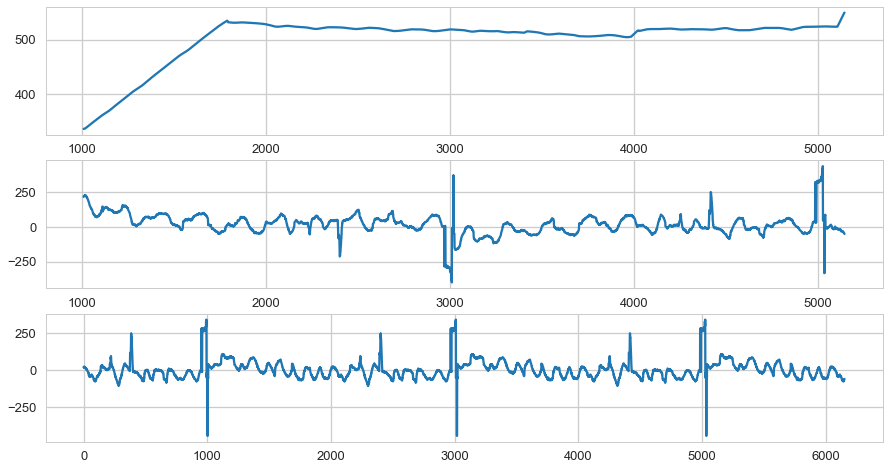

In [119]:
res = sm.tsa.seasonal_decompose(anomalies['up_depth'].interpolate(),
                                freq=2016,
                                model='additive')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1)
res.resid.plot(ax=ax2)
res.seasonal.plot(ax=ax3)

### Showing the general plot of given data

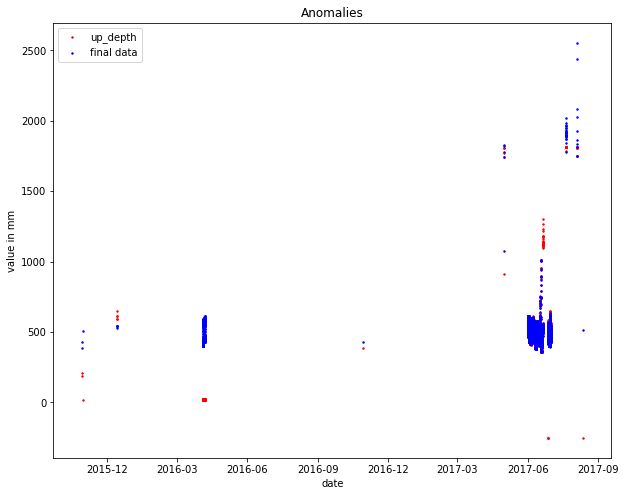

In [49]:
plt.figure(figsize=(10, 8))

plt.scatter(anomalies['time'].values.reshape(-1,1), anomalies['up_depth'], color="red",
    label="up_depth", s=2)
plt.scatter(anomalies['time'].values.reshape(-1,1), anomalies['d_final'], c='blue', label="final data",s=2)
plt.xlabel("date")
plt.ylabel("value in mm")
plt.title("Anomalies")
plt.legend()
plt.show()

### Showing data in a given range

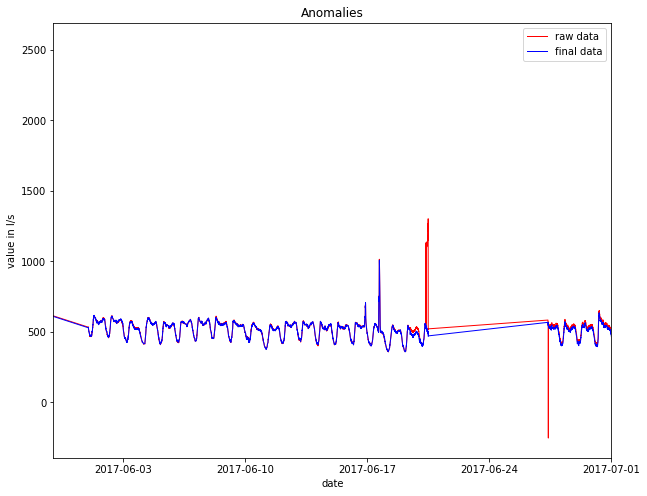

In [51]:
plt.figure(figsize=(10, 8))
plt.plot(anomalies['time'], anomalies['up_depth'], color="red",
    label="raw data", linewidth=1)
plt.plot(anomalies['time'], anomalies['d_final'], c='blue', label="final data",linewidth=1)
plt.xlim(('2017-05-30'),('2017-07-01'))
plt.xlabel("date")
plt.ylabel("value in l/s")
plt.title("Anomalies")
plt.legend()
plt.show()

### Median absolute deviation and standard deviation

In [66]:
x = anomalies['up_depth']
y = anomalies['time']

def mad(data, axis=None):
    return np.mean(np.abs(data - np.mean(data, axis)), axis)
_mad = np.abs(x - np.median(x)) / mad(x)

_sd = np.abs(x - np.mean(x)) / np.std(x)

calc = pd.concat([x, y, _mad, _sd], axis=1).dropna()
calc.columns = ['up_depth','time','_mad','_sd']

In [67]:
calc.head()

,up_depth,time,_mad,_sd
0,184.360001,2015-10-30 01:40:00,2.697156,1.331801
1,209.600006,2015-10-30 04:40:00,2.496758,1.213300
2,15.880000,2015-10-30 13:20:00,4.034836,2.122810
3,614.890015,2015-12-14 19:10:00,0.721123,0.689526
4,614.419983,2015-12-14 19:15:00,0.717391,0.687319


### Showing raw data, median and standard deviation together

Scaling the data

In [72]:
min_max_scaler = preprocessing.MinMaxScaler()
flow_scaled = min_max_scaler.fit_transform(anomalies['up_depth'].values.reshape(-1,1))

In [73]:
mad_scaled = min_max_scaler.fit_transform(calc['_mad'].values.reshape(-1,1))

In [74]:
sd_scaled = min_max_scaler.fit_transform(calc['_sd'].values.reshape(-1,1))

Plotting the data,median and standard deviation

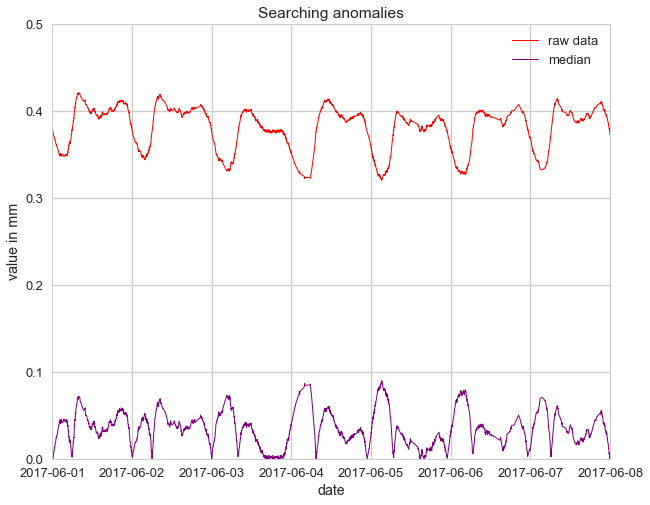

In [109]:
plt.figure(figsize=(10, 8))
plt.plot(anomalies['time'], flow_scaled, color="red",
    label="raw data", linewidth=1)
plt.plot(anomalies['time'], mad_scaled, c='purple', label="median",linewidth=1)
#plt.plot(anomalies['time'], sd_scaled, c='orange', label="sd",linewidth=1)
plt.xlim(('2017-06-01'),('2017-06-08'))
plt.ylim(0,0.5)
plt.xlabel("date")
plt.ylabel("value in mm")
plt.title("Searching anomalies")
plt.legend()
plt.show()

### Moving average

In [76]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [81]:
x = anomalies['mp1_flow']
y = anomalies['time']

Plotting raw data and moving average

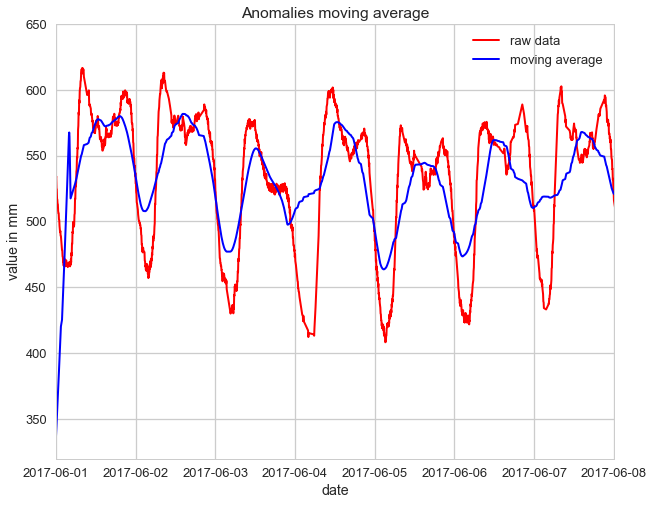

In [112]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

plt.plot(anomalies['time'].values.reshape(-1,1), anomalies['up_depth'], color="red",
    label="raw data", linewidth=2)
x_av = movingaverage(x,100)

plt.plot(y.values.reshape(-1,1), x_av, c='blue',label="moving average",linewidth=2)
plt.xlim(('2017-06-01'),('2017-06-8'))
plt.ylim(320,650)
plt.xlabel("date")
plt.ylabel("value in mm")
plt.title("Anomalies moving average")
plt.legend()
plt.show()

Plotting raw data, final data and moving average

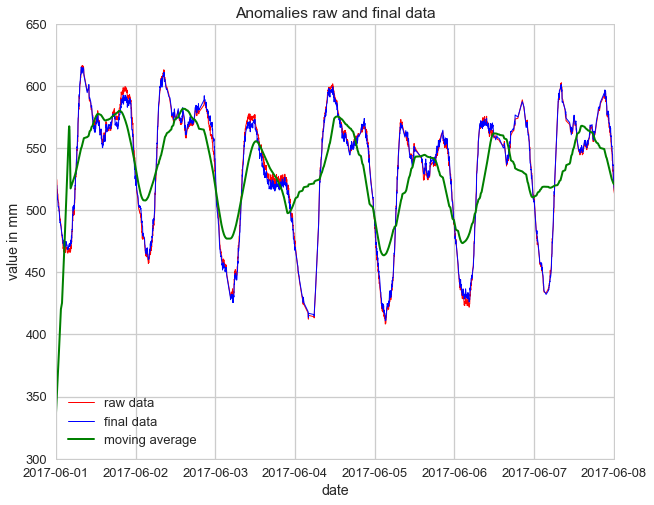

In [118]:
plt.figure(figsize=(10, 8))
plt.plot(anomalies['time'], anomalies['up_depth'], color="red",
    label="raw data", linewidth=1)
z_av = movingaverage(x,100)
plt.plot(anomalies['time'], anomalies['d_final'], c='blue', label="final data",linewidth=1)
plt.plot(y, z_av, c='green',label="moving average",linewidth=2)
plt.xlim(('2017-06-01'),('2017-06-8'))
plt.ylim(300, 650)
plt.xlabel("date")
plt.ylabel("value in mm")
plt.title("Anomalies raw and final data")
plt.legend()
plt.show()